In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from PIL import Image, UnidentifiedImageError

root_folder = "./images"

labels = []
file_paths = []

for tree_folder in os.listdir(root_folder):
    tree_path = os.path.join(root_folder, tree_folder)

    if os.path.isdir(tree_path):
        for file in os.listdir(tree_path):
            file_path = os.path.join(tree_path, file)
            
            
            try:
                with Image.open(file_path) as img:
                    labels.append(tree_folder)
                    file_paths.append(file_path)
            except (IOError, UnidentifiedImageError):
                
                print(f"Removing damaged file: {file_path}")
                os.remove(file_path)

df = pd.DataFrame({"label": labels, "path": file_paths})

print(df)

       label                            path
0      고로쇠나무  ./images\고로쇠나무\12226_고로쇠나무.jpg
1      고로쇠나무  ./images\고로쇠나무\12227_고로쇠나무.jpg
2      고로쇠나무  ./images\고로쇠나무\12228_고로쇠나무.jpg
3      고로쇠나무  ./images\고로쇠나무\12229_고로쇠나무.jpg
4      고로쇠나무  ./images\고로쇠나무\12230_고로쇠나무.jpg
...      ...                             ...
37769   황칠나무    ./images\황칠나무\53360_황칠나무.jpg
37770   황칠나무    ./images\황칠나무\53361_황칠나무.jpg
37771   황칠나무    ./images\황칠나무\53362_황칠나무.jpg
37772   황칠나무    ./images\황칠나무\53363_황칠나무.jpg
37773   황칠나무    ./images\황칠나무\53364_황칠나무.jpg

[37774 rows x 2 columns]


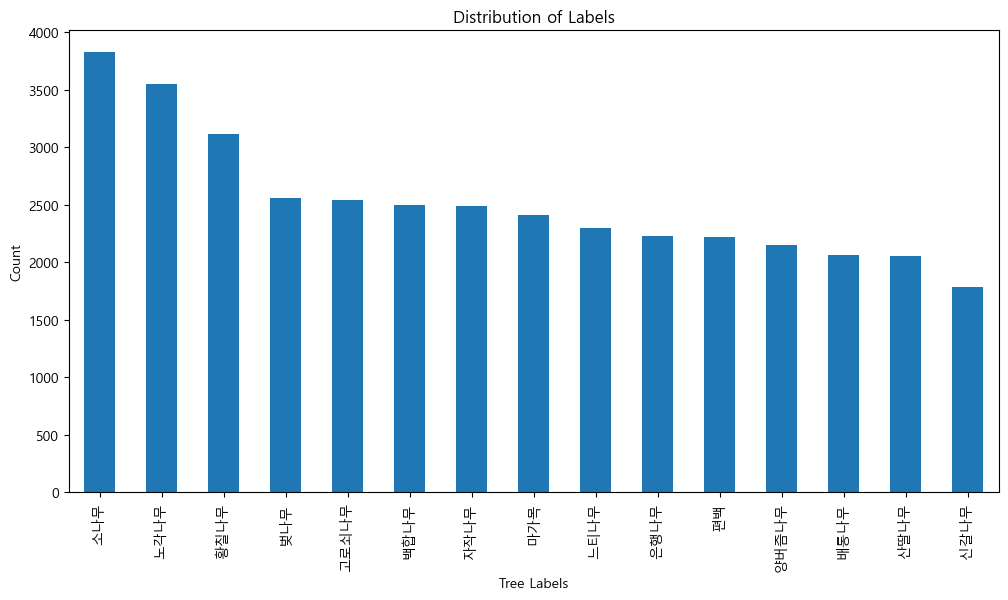

In [3]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

label_counts = df['label'].value_counts()

plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Tree Labels')
plt.ylabel('Count')
plt.show()

In [4]:
print(df['label'].unique())
print(len(df['label'].unique()))

['고로쇠나무' '노각나무' '느티나무' '마가목' '배롱나무' '백합나무' '벚나무' '산딸나무' '소나무' '신갈나무'
 '양버즘나무' '은행나무' '자작나무' '편백' '황칠나무']
15


In [5]:


label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")
print(f"Validation set: {len(valid)} samples")

Train set: 26441 samples
Test set: 5666 samples
Validation set: 5667 samples


In [6]:
train

,path,label_encoded
9820,./images\마가목\8937_마가목.jpg,3
29604,./images\은행나무\21364_은행나무.jpg,11
1041,./images\고로쇠나무\13270_고로쇠나무.jpg,0
7803,./images\느티나무\11713_느티나무.jpg,2
16333,./images\벚나무\1876_벚나무.jpg,6
...,...,...
24657,./images\신갈나무\22993_신갈나무.jpg,9
28451,./images\은행나무\20209_은행나무.jpg,11
33775,./images\편백\16103_편백.jpg,13
21140,./images\소나무\58679_소나무.jpg,8


In [7]:
decoded_predictions = label_encoder.inverse_transform([8, 0, 2])

In [8]:
decoded_predictions

array(['소나무', '고로쇠나무', '느티나무'], dtype=object)

In [9]:
df

,label,path,label_encoded
0,고로쇠나무,./images\고로쇠나무\12226_고로쇠나무.jpg,0
1,고로쇠나무,./images\고로쇠나무\12227_고로쇠나무.jpg,0
2,고로쇠나무,./images\고로쇠나무\12228_고로쇠나무.jpg,0
3,고로쇠나무,./images\고로쇠나무\12229_고로쇠나무.jpg,0
4,고로쇠나무,./images\고로쇠나무\12230_고로쇠나무.jpg,0
...,...,...,...
37769,황칠나무,./images\황칠나무\53360_황칠나무.jpg,14
37770,황칠나무,./images\황칠나무\53361_황칠나무.jpg,14
37771,황칠나무,./images\황칠나무\53362_황칠나무.jpg,14
37772,황칠나무,./images\황칠나무\53363_황칠나무.jpg,14


In [17]:
import cv2

BATCH_SIZE = 32

class TreeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        out = dict()
        img_path = self.dataframe['path'].iloc[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        image = image.clone().detach().requires_grad_(True).to(torch.float)
        label = torch.tensor(self.dataframe['label_encoded'].iloc[idx], dtype=torch.long)

        return image, label


transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

train_dataset = TreeDataset(dataframe=train, transform=transform)
test_dataset = TreeDataset(dataframe=test, transform=transform)
valid_dataset = TreeDataset(dataframe=valid, transform=transform)
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

26441
5666
5667


In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

3306
709
709


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
model1 = models.resnet50(pretrained=True).to(device)
num_classes = len(df['label_encoded'].unique())

for param in model1.parameters():
    param.requires_grad = False

model1.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace = True),
    nn.Linear(128, num_classes)).to(device)



c:\Users\com\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\com\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# 저장된 모델 불러오기
model_path = './tree_classifier_normalize.pth'
model = model1
model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 95.08%


## HUFS tree

In [24]:
tree_labels = ['고로쇠나무', '노각나무', '느티나무', '마가목', '배롱나무', '백합나무', '벚나무', '산딸나무', '소나무', '신갈나무',
               '양버즘나무', '은행나무', '자작나무', '편백', '황칠나무']

label_encoding = {tree: label for label, tree in enumerate(tree_labels)}
label_decoding = {label: tree for label, tree in enumerate(tree_labels)}

print("Label Encoding:", label_encoding)
print("Label Decoding:", label_decoding)

Label Encoding: {'고로쇠나무': 0, '노각나무': 1, '느티나무': 2, '마가목': 3, '배롱나무': 4, '백합나무': 5, '벚나무': 6, '산딸나무': 7, '소나무': 8, '신갈나무': 9, '양버즘나무': 10, '은행나무': 11, '자작나무': 12, '편백': 13, '황칠나무': 14}
Label Decoding: {0: '고로쇠나무', 1: '노각나무', 2: '느티나무', 3: '마가목', 4: '배롱나무', 5: '백합나무', 6: '벚나무', 7: '산딸나무', 8: '소나무', 9: '신갈나무', 10: '양버즘나무', 11: '은행나무', 12: '자작나무', 13: '편백', 14: '황칠나무'}


In [41]:
hufs_df = pd.DataFrame({'path':['./hufs_tree/ginkgo_1.jpg', './hufs_tree/ginkgo_2.jpg', './hufs_tree/ginkgo_3.jpg',
                               './hufs_tree/sakura_1.jpg', './hufs_tree/sakura_2.jpg', './hufs_tree/sakura_3.jpg'],
                             'label_encoded':[11, 11, 11, 6, 6, 6]})

hufs_dataset = TreeDataset(dataframe = hufs_df, transform=transform)
hufs_loader = DataLoader(hufs_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [42]:
hufs_df

,path,label_encoded
0,./hufs_tree/ginkgo_1.jpg,11
1,./hufs_tree/ginkgo_2.jpg,11
2,./hufs_tree/ginkgo_3.jpg,11
3,./hufs_tree/sakura_1.jpg,6
4,./hufs_tree/sakura_2.jpg,6
5,./hufs_tree/sakura_3.jpg,6


In [43]:
predictions = []
with torch.no_grad():
    for images, labels in hufs_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())


In [55]:
for i, prediction in enumerate(predictions):
    tree_class = label_decoding[prediction]
    print(f"Tree {i + 1}: Predicted Class - {tree_class}, True Class - {label_decoding[hufs_df.label_encoded[i]]}")
    plt.show()

Tree 1: Predicted Class - 은행나무, True Class - 은행나무
Tree 2: Predicted Class - 신갈나무, True Class - 은행나무
Tree 3: Predicted Class - 신갈나무, True Class - 은행나무
Tree 4: Predicted Class - 벚나무, True Class - 벚나무
Tree 5: Predicted Class - 벚나무, True Class - 벚나무
Tree 6: Predicted Class - 벚나무, True Class - 벚나무
